In [ ]:
from google.colab import files
files.upload()

Saving quickdraw_crabs.npy to quickdraw_crabs.npy
Saving quickdraw_faces.npy to quickdraw_faces.npy


{'quickdraw_crabs.npy': b'\x93NUMPY\x01\x00v\x00{\'descr\': \'|u1\', \'fortran_order\': False, \'shape\': (1000, 28, 28), }                                                  \n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x)\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xffw\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xffx\x00\

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, UpSampling2D, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [ ]:
faces=np.load("/content/quickdraw_faces.npy")
crabs=np.load("/content/quickdraw_crabs.npy")

In [ ]:
faces=faces.astype("float32")/255.0
crabs=crabs.astype("float32")/255.0

In [ ]:
faces.shape

(1000, 28, 28)

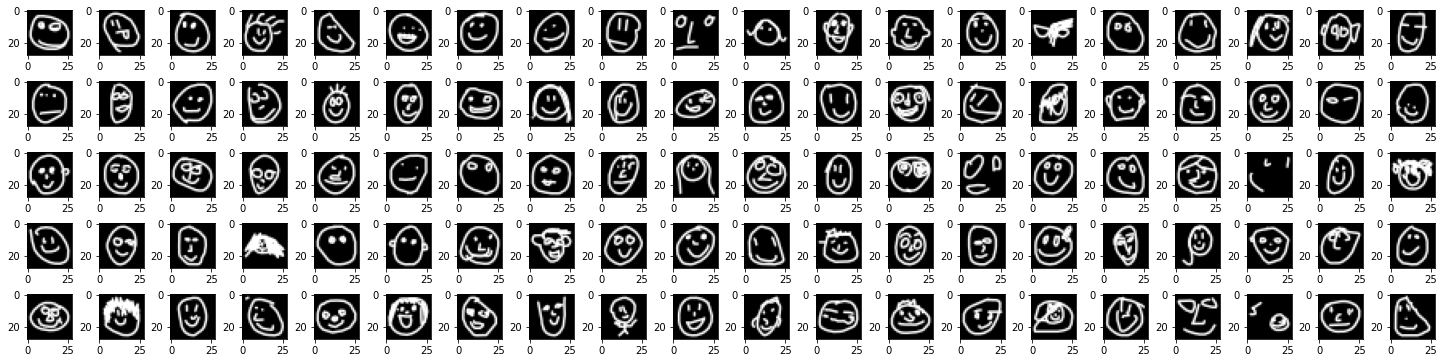

In [ ]:
rows, cols = 5, 20
fig, axs = plt.subplots(rows, cols, figsize = (20, 5))
for i in range(rows):
    for j in range(cols):
        axs[i][j].imshow(faces[cols*i + j], cmap="gray")
fig.tight_layout(pad=0.5)
plt.show()

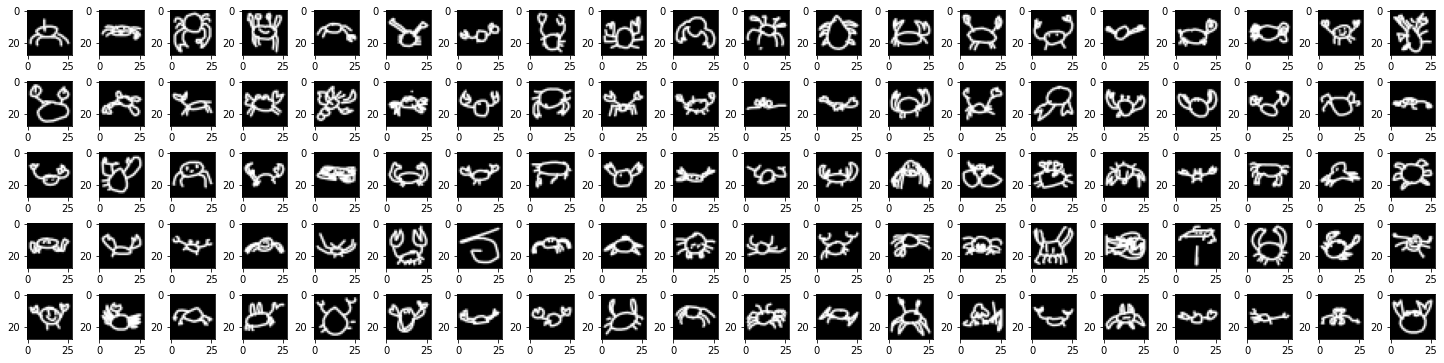

In [ ]:
rows, cols = 5, 20
fig, axs = plt.subplots(rows, cols, figsize = (20, 5))
for i in range(rows):
    for j in range(cols):
        axs[i][j].imshow(crabs[cols*i + j], cmap="gray")
fig.tight_layout(pad=0.5)
plt.show()

In [ ]:
D_conv_filters=[64, 64, 128, 128]
D_conv_kernels=[5, 5, 5, 5]
D_conv_strides=[2, 2, 2, 1]
D_dropout_rate=0.4
D_bn_momentum=None
D_lr=0.0004

z_dim=100

G_conv_filters=[128, 64, 64, 1]
G_conv_kernels=[5, 5, 5, 5]
G_conv_strides=[1, 1, 1, 1]
G_dropout_rate=None
G_bn_momentum=0.9
G_lr=0.0004

In [ ]:
D_input=Input((28, 28, 1))
x=D_input
for i, (f, k, s) in enumerate(zip(D_conv_filters, D_conv_kernels, D_conv_strides)):
    x=Conv2D(f, k, s, "same", name="D_conv_"+str(i))(x)
    x=Activation("relu")(x)
    if D_dropout_rate:
        x=Dropout(D_dropout_rate)(x)
x=Flatten()(x)
D_output=Dense(1, activation="sigmoid")(x)
D_face=Model(D_input, D_output)

In [ ]:
D_face.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
D_conv_0 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
D_conv_1 (Conv2D)            (None, 7, 7, 64)          102464    
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0     

In [ ]:
D_face.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
D_face.trainable=False

In [ ]:
G_input=Input((z_dim))
x=Dense(3136)(G_input)
x=BatchNormalization(momentum=G_bn_momentum)(x)
x=Activation("relu")(x)
x=Reshape((7, 7, 64))(x)
if G_dropout_rate:
    x=Dropout(G_dropout_rate)(x)
for i, (f, k, s) in enumerate(zip(G_conv_filters, G_conv_kernels, G_conv_strides)):
    if i<2:
        x=UpSampling2D()(x)
    x=Conv2D(f, k, s, "same", name="G_conv_"+str(i))(x)
    if i!=3:
        x=BatchNormalization(momentum=G_bn_momentum)(x)
        x=Activation("relu")(x)
    else:
        x=Activation("tanh")(x)
    if G_dropout_rate:
        x=Dropout(G_dropout_rate)(x)
G_output=x
G_face=Model(G_input, G_output)

In [ ]:
G_face.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation_4 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
G_conv_0 (Conv2D)            (None, 14, 14, 128)       2049

In [ ]:
GD_face=Model(G_input, D_face(G_output))
GD_face.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
GD_face.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation_4 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
G_conv_0 (Conv2D)            (None, 14, 14, 128)       2049

In [ ]:
epochs=500
batch_size=64

g2d_ratio=2
valid=np.ones((batch_size, 1))
fake=np.zeros((batch_size, 1))
for epoch in range(epochs):
    #training D
    idx=np.random.randint(0, faces.shape[0], batch_size)
    true_imgs=faces[idx]
    D_loss_real, D_acc_real=D_face.train_on_batch(true_imgs, valid)

    noise=np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs=G_face.predict(noise)
    D_loss_fake, D_acc_fake=D_face.train_on_batch(gen_imgs, fake)

    for i in range(g2d_ratio):
        #training G
        noise=np.random.normal(0, 1, (batch_size, z_dim))
        G_loss, G_acc=GD_face.train_on_batch(noise, valid)
    print("{}/{}: D loss: {:.3f}(real) {:.3f}(fake) D acc: {:.3f}(real) {:.3f}(fake) G loss: {:.3f} G acc: {:.3f}"\
          .format(epoch+1, epochs, D_loss_real, D_loss_fake, D_loss_fake, D_acc_fake, G_loss, G_acc))


1/500: D loss: 0.696(real) 1.063(fake) D acc: 1.063(real) 0.000(fake) G loss: 0.668 G acc: 1.000
2/500: D loss: 0.683(real) 0.715(fake) D acc: 0.715(real) 0.000(fake) G loss: 0.677 G acc: 1.000
3/500: D loss: 0.686(real) 0.713(fake) D acc: 0.713(real) 0.000(fake) G loss: 0.687 G acc: 1.000
4/500: D loss: 0.687(real) 0.699(fake) D acc: 0.699(real) 0.000(fake) G loss: 0.687 G acc: 1.000
5/500: D loss: 0.687(real) 0.698(fake) D acc: 0.698(real) 0.000(fake) G loss: 0.682 G acc: 1.000
6/500: D loss: 0.685(real) 0.696(fake) D acc: 0.696(real) 0.000(fake) G loss: 0.661 G acc: 1.000
7/500: D loss: 0.677(real) 0.748(fake) D acc: 0.748(real) 0.000(fake) G loss: 0.679 G acc: 1.000
8/500: D loss: 0.685(real) 0.701(fake) D acc: 0.701(real) 0.000(fake) G loss: 0.676 G acc: 1.000
9/500: D loss: 0.684(real) 0.726(fake) D acc: 0.726(real) 0.000(fake) G loss: 0.692 G acc: 0.828
10/500: D loss: 0.691(real) 0.696(fake) D acc: 0.696(real) 0.031(fake) G loss: 0.693 G acc: 0.500
11/500: D loss: 0.691(real) 0

In [ ]:
noise=np.random.normal(0, 1, (100, z_dim))
gen_imgs=G_face.predict(noise)

In [ ]:
gen_imgs=np.reshape(gen_imgs, gen_imgs.shape[:-1])

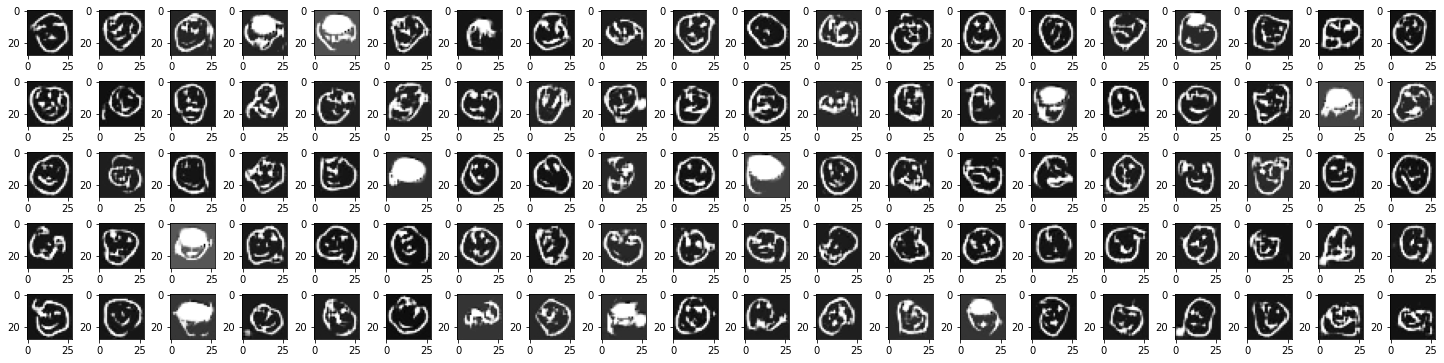

In [ ]:
rows, cols = 5, 20
fig, axs = plt.subplots(rows, cols, figsize = (20, 5))
for i in range(rows):
    for j in range(cols):
        axs[i][j].imshow(gen_imgs[cols*i + j], cmap="gray")
fig.tight_layout(pad=0.5)
plt.show()

In [ ]:
D_crab=Model(D_input, D_output)
D_crab.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
D_crab.trainable=False
G_crab=Model(G_input, G_output)
GD_crab=Model(G_input, D_crab(G_output))
GD_crab.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

epochs=300
batch_size=64

g2d_ratio=1
valid=np.ones((batch_size, 1))
fake=np.zeros((batch_size, 1))
for epoch in range(epochs):
    #training D
    idx=np.random.randint(0, crabs.shape[0], batch_size)
    true_imgs=crabs[idx]
    D_loss_real, D_acc_real=D_crab.train_on_batch(true_imgs, valid)

    noise=np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs=G_crab.predict(noise)
    D_loss_fake, D_acc_fake=D_crab.train_on_batch(gen_imgs, fake)

    for i in range(g2d_ratio):
        #training G
        noise=np.random.normal(0, 1, (batch_size, z_dim))
        G_loss, G_acc=GD_crab.train_on_batch(noise, valid)
    print("{}/{}: D loss: {:.3f}(real) {:.3f}(fake) D acc: {:.3f}(real) {:.3f}(fake) G loss: {:.3f} G acc: {:.3f}"\
          .format(epoch+1, epochs, D_loss_real, D_loss_fake, D_loss_fake, D_acc_fake, G_loss, G_acc))

1/300: D loss: 1.335(real) 6.586(fake) D acc: 6.586(real) 0.000(fake) G loss: 0.011 G acc: 1.000
2/300: D loss: 1.439(real) 0.001(fake) D acc: 0.001(real) 1.000(fake) G loss: 8.757 G acc: 0.000
3/300: D loss: 1.587(real) 0.000(fake) D acc: 0.000(real) 1.000(fake) G loss: 0.956 G acc: 0.594
4/300: D loss: 1.617(real) 0.177(fake) D acc: 0.177(real) 0.938(fake) G loss: 0.262 G acc: 0.922
5/300: D loss: 1.535(real) 0.738(fake) D acc: 0.738(real) 0.656(fake) G loss: 0.064 G acc: 0.984
6/300: D loss: 1.189(real) 1.761(fake) D acc: 1.761(real) 0.422(fake) G loss: 0.030 G acc: 1.000
7/300: D loss: 1.597(real) 2.951(fake) D acc: 2.951(real) 0.188(fake) G loss: 0.072 G acc: 0.969
8/300: D loss: 1.425(real) 4.018(fake) D acc: 4.018(real) 0.047(fake) G loss: 0.113 G acc: 0.969
9/300: D loss: 1.396(real) 4.409(fake) D acc: 4.409(real) 0.094(fake) G loss: 0.076 G acc: 0.969
10/300: D loss: 1.544(real) 4.587(fake) D acc: 4.587(real) 0.031(fake) G loss: 0.015 G acc: 1.000
11/300: D loss: 1.505(real) 4

KeyboardInterrupt: ignored

In [ ]:
noise=np.random.normal(0, 1, (100, z_dim))
gen_imgs=G_crab.predict(noise)
gen_imgs=np.reshape(gen_imgs, gen_imgs.shape[:-1])

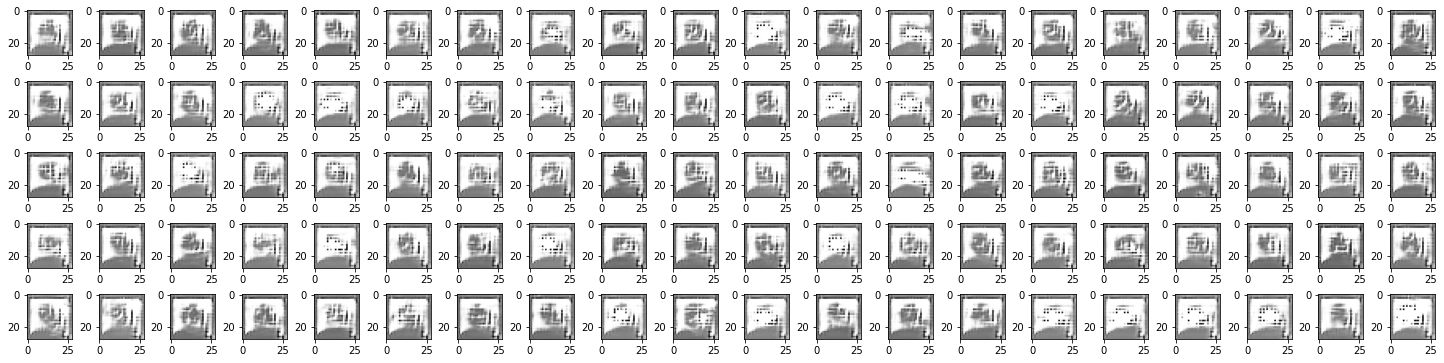

In [ ]:
rows, cols = 5, 20
fig, axs = plt.subplots(rows, cols, figsize = (20, 5))
for i in range(rows):
    for j in range(cols):
        axs[i][j].imshow(gen_imgs[cols*i + j], cmap="gray")
fig.tight_layout(pad=0.5)
plt.show()